# imports

In [17]:
import boto3
import math
import pandas as pd

# constants

In [18]:
BUCKET = "classification-by-example-sagemaker"
DATA_LOCAL = "../data/words-spam.csv"
S3 = boto3.client("s3")
TEST_LOCAL = "../data/test.csv"
TEST_REMOTE = "data/test/test.csv"
TRAIN_LOCAL = "../data/train.csv"
TRAIN_REMOTE = "data/train/train.csv"
VALIDATION_LOCAL = "../data/validation.csv"
VALIDATION_REMOTE = "data/validation/validation.csv"

# create dataframe

In [19]:
working_df = pd.read_csv(DATA_LOCAL)
working_df.head()

,words,spam
0,4,0
1,4,1
2,5,0
3,2,0
4,9,1


# balance

In [20]:
not_spam_count = len(working_df[working_df.spam == 0])
spam_count = len(working_df[working_df.spam == 1])
print(f"not spam count: {not_spam_count}")
print(f"spam count: {spam_count}")

not spam count: 499
spam count: 500


# probability

<Axes: xlabel='words'>

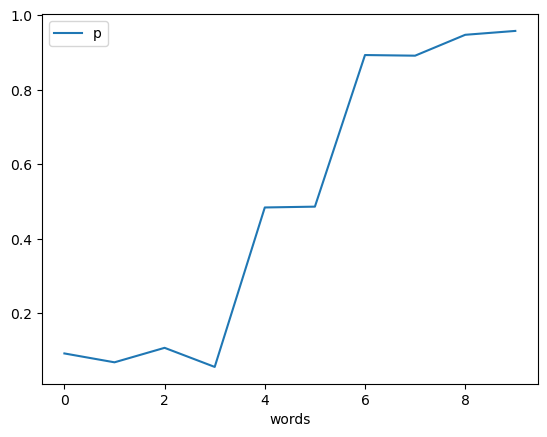

In [21]:
probability_df = pd.DataFrame({"words": [], "p": []})
for i in range(10):
    count = len(working_df[working_df.words == i])
    spam = len(working_df[(working_df.spam == 1) & (working_df.words == i)])
    probability_df = pd.concat([probability_df, pd.DataFrame({"words": [i], "p": [spam / count]})], ignore_index=True)
probability_df.plot(x="words", y="p")

# log-ends

<Axes: xlabel='words'>

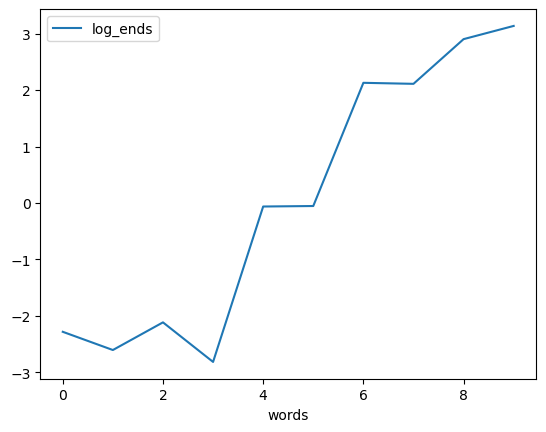

In [22]:
def logit(value):
    return math.log(value / (1 - value))

log_ends_df = probability_df[["words"]].copy()
log_ends_df["log_ends"] = probability_df["p"].apply(logit)
log_ends_df.plot(x="words", y="log_ends")

# split

In [23]:
length_all = len(working_df)
length_train_validation = math.trunc(length_all * 0.8)
length_train = math.trunc(length_train_validation * 0.75)
end_train = length_train - 1
start_validation = length_train
end_validation = length_train_validation - 1
start_test = length_train_validation
train_df = working_df.iloc[:end_train]
validation_df = working_df.iloc[start_validation:end_validation]
test_df = working_df.iloc[start_test:]
print(f"train percent of data: {math.trunc((len(train_df) / length_all) * 100)}")
print(f"validation percent of data: {math.trunc((len(validation_df) / length_all) * 100)}")
print(f"test percent of data: {math.trunc((len(test_df) / length_all) * 100)}")

train percent of data: 59
validation percent of data: 19
test percent of data: 20


# upload

In [24]:
train_df.to_csv(TRAIN_LOCAL, index=False, header=False, columns=["spam", "words"])
validation_df.to_csv(VALIDATION_LOCAL, index=False, header=False, columns=["spam", "words"])
test_df.to_csv(TEST_LOCAL, index=False, header=False, columns=["spam", "words"])
S3.upload_file(TRAIN_LOCAL, BUCKET, TRAIN_REMOTE)
S3.upload_file(VALIDATION_LOCAL, BUCKET, VALIDATION_REMOTE)
S3.upload_file(TEST_LOCAL, BUCKET, TEST_REMOTE)